In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils
from keras.models import Sequential
from keras import layers


Using TensorFlow backend.


In [2]:
plt.style.use('ggplot')

data = pd.read_json('News_Category_Dataset_v2.json', orient='values', lines=True)

# Ograniczenie zakresu czasowego danych do roku 2012
data = data.loc[data['date'].dt.year == 2012]

num_categories = len(set(data.category))

X = data['headline'].values
y = data['category'].values


In [3]:
#RANDOM FOREST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print('Accuracy:', score)

Accuracy: 0.631330526853


In [5]:
# Basic DL Model
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.25, random_state=100)

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train_v = vectorizer.transform(X_train)
X_test_v = vectorizer.transform(X_test)

input_dim = X_train_v.shape[1]
model = Sequential()
model.add(layers.Dense(21, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(num_categories, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train_v, y_train, epochs=20, verbose=2, validation_data=(X_test_v, y_test), batch_size=512)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 21)                449358    
_________________________________________________________________
dense_4 (Dense)              (None, 21)                462       
Total params: 449,820
Trainable params: 449,820
Non-trainable params: 0
_________________________________________________________________
Train on 23516 samples, validate on 7839 samples
Epoch 1/20
 - 5s - loss: 2.8828 - acc: 0.3573 - val_loss: 2.6652 - val_acc: 0.4349
Epoch 2/20
 - 5s - loss: 2.4251 - acc: 0.4690 - val_loss: 2.2404 - val_acc: 0.4774
Epoch 3/20
 - 5s - loss: 2.0220 - acc: 0.5314 - val_loss: 1.9501 - val_acc: 0.5243
Epoch 4/20
 - 5s - loss: 1.7213 - acc: 0.5944 - val_loss: 1.7394 - val_acc: 0.5723
Epoch 5/20
 - 5s - loss: 1.4784 - acc: 0.6499 - val_loss: 1.5749 - val_acc: 0.6085
Epoch 6/20
 - 5s - loss: 1.2759 - acc: 0.7013 - val_loss: 1.4449 - v

Pokrycie słownika przez wytrenowany model: 4.095004095004095e-05
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           1221000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 21)                1071      
_________________________________________________________________
dense_6 (Dense)              (None, 21)                462       
Total params: 1,222,533
Trainable params: 1,222,533
Non-trainable params: 0
__________________

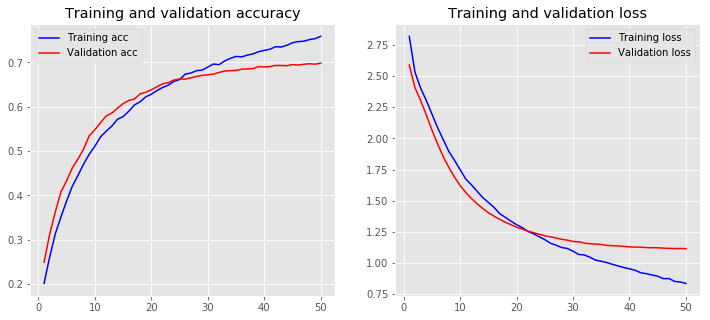

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_g = tokenizer.texts_to_sequences(X_train)
X_test_g = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 100

X_train_g = pad_sequences(X_train_g, padding='post', maxlen=maxlen)
X_test_g = pad_sequences(X_test_g, padding='post', maxlen=maxlen)

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 50

embedding_matrix = create_embedding_matrix(
    'glove/glove.6B.50d.txt',  # Source: http://nlp.stanford.edu/data/glove.6B.zip
    tokenizer.word_index,
    embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Pokrycie słownika przez wytrenowany model:', nonzero_elements / vocab_size)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(21, activation='relu'))
model.add(layers.Dense(num_categories, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train_g, y_train, epochs=50, verbose=2, validation_data=(X_test_g, y_test), batch_size=512)

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)
plt.show()

In [15]:
from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, DocumentRNNEmbeddings
from flair.trainers import ModelTrainer
from pathlib import Path


from flair.models import TextClassifier


corpus = NLPTaskDataFetcher.load_classification_corpus(Path('./'),
                                                       train_file='train.csv', test_file='test.csv', dev_file='dev.csv')

#embedding = [BertEmbeddings()]
#embedding = [BertEmbeddings('bert-base-multilingual-cased')]
#embedding = [WordEmbeddings('glove'), FlairEmbeddings('news-forward-fast'), FlairEmbeddings('news-backward-fast')]

embedding = [WordEmbeddings('glove')]


document_embeddings = DocumentRNNEmbeddings(embedding, hidden_size=64)
                                             #,reproject_words=True, reproject_words_dimension=32)


classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(),
                            multi_label=False)

trainer = ModelTrainer(classifier, corpus)

trainer.train('./', max_epochs=20)




2019-04-12 22:00:55,741 Reading data from .
2019-04-12 22:00:55,746 Train: train.csv
2019-04-12 22:00:55,748 Dev: dev.csv
2019-04-12 22:00:55,749 Test: test.csv
2019-04-12 22:01:01,684 this function is deprecated, use smart_open.open instead
2019-04-12 22:01:02,534 ----------------------------------------------------------------------------------------------------
2019-04-12 22:01:02,535 Evaluation method: MICRO_F1_SCORE
2019-04-12 22:01:02,537 ----------------------------------------------------------------------------------------------------
2019-04-12 22:01:02,608 epoch 1 - iter 0/783 - loss 0.28406382
2019-04-12 22:01:07,493 epoch 1 - iter 78/783 - loss 0.25022929
2019-04-12 22:01:10,415 epoch 1 - iter 156/783 - loss 0.23774115
2019-04-12 22:01:13,294 epoch 1 - iter 234/783 - loss 0.23129634
2019-04-12 22:01:16,242 epoch 1 - iter 312/783 - loss 0.22598298
2019-04-12 22:01:19,122 epoch 1 - iter 390/783 - loss 0.22214262
2019-04-12 22:01:22,002 epoch 1 - iter 468/783 - loss 0.2186295

2019-04-12 22:08:30,544 epoch 7 - iter 624/783 - loss 0.17885467
2019-04-12 22:08:32,597 epoch 7 - iter 702/783 - loss 0.17884347
2019-04-12 22:08:34,634 epoch 7 - iter 780/783 - loss 0.17886746
2019-04-12 22:08:34,715 ----------------------------------------------------------------------------------------------------
2019-04-12 22:08:34,721 EPOCH 7 done: loss 0.1789 - lr 0.1000 - bad epochs 0
2019-04-12 22:08:54,711 DEV  : loss 0.16270462 - f-score 0.4067 - acc 0.2552
2019-04-12 22:09:14,553 TEST : loss 0.17109485 - f-score 0.3648 - acc 0.2231
2019-04-12 22:09:18,987 ----------------------------------------------------------------------------------------------------
2019-04-12 22:09:19,050 epoch 8 - iter 0/783 - loss 0.21069780
2019-04-12 22:09:21,042 epoch 8 - iter 78/783 - loss 0.17430586
2019-04-12 22:09:23,240 epoch 8 - iter 156/783 - loss 0.17696243
2019-04-12 22:09:25,852 epoch 8 - iter 234/783 - loss 0.17693163
2019-04-12 22:09:28,563 epoch 8 - iter 312/783 - loss 0.17732848
20

2019-04-12 22:16:22,616 epoch 14 - iter 390/783 - loss 0.16546631
2019-04-12 22:16:25,268 epoch 14 - iter 468/783 - loss 0.16618141
2019-04-12 22:16:27,998 epoch 14 - iter 546/783 - loss 0.16628222
2019-04-12 22:16:30,409 epoch 14 - iter 624/783 - loss 0.16574808
2019-04-12 22:16:32,489 epoch 14 - iter 702/783 - loss 0.16587594
2019-04-12 22:16:34,501 epoch 14 - iter 780/783 - loss 0.16594774
2019-04-12 22:16:34,578 ----------------------------------------------------------------------------------------------------
2019-04-12 22:16:34,579 EPOCH 14 done: loss 0.1659 - lr 0.1000 - bad epochs 0
2019-04-12 22:16:54,023 DEV  : loss 0.15767375 - f-score 0.4306 - acc 0.2744
2019-04-12 22:17:14,009 TEST : loss 0.16452150 - f-score 0.3924 - acc 0.2441
2019-04-12 22:17:18,486 ----------------------------------------------------------------------------------------------------
2019-04-12 22:17:18,553 epoch 15 - iter 0/783 - loss 0.18302733
2019-04-12 22:17:21,123 epoch 15 - iter 78/783 - loss 0.16

2019-04-12 22:24:41,462 MICRO_AVG: acc 0.2545 - f1-score 0.4058
2019-04-12 22:24:41,512 MACRO_AVG: acc 0.0009 - f1-score 0.001199801633605601
2019-04-12 22:24:41,523 ARTS       tp: 16 - fp: 5 - fn: 8 - tn: 3100 - precision: 0.7619 - recall: 0.6667 - accuracy: 0.5517 - f1-score: 0.7111
2019-04-12 22:24:41,524 BLACK      tp: 14 - fp: 16 - fn: 29 - tn: 3070 - precision: 0.4667 - recall: 0.3256 - accuracy: 0.2373 - f1-score: 0.3836
2019-04-12 22:24:41,525 BUSINESS,"""But tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,527 BUSINESS,"$1 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,529 BUSINESS,"'$5 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,530 BUSINESS,"'Cheap' tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.000

2019-04-12 22:24:41,597 BUSINESS,"CNOOC, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,598 BUSINESS,"Can tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,599 BUSINESS,"Canada's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,600 BUSINESS,"Car tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,601 BUSINESS,"Carol tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,602 BUSINESS,"Central tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,603 BUSINESS,"Cheapest tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.00

2019-04-12 22:24:41,671 BUSINESS,"Foreign tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,672 BUSINESS,"Former tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,674 BUSINESS,"Four tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,675 BUSINESS,"Frances tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,677 BUSINESS,"Francois tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,680 BUSINESS,"Frank tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,681 BUSINESS,"Free tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0

2019-04-12 22:24:41,750 BUSINESS,"Kline tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,752 BUSINESS,"Knowing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,757 BUSINESS,"Koch tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,759 BUSINESS,"Kristen tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,760 BUSINESS,"LIBOR tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,761 BUSINESS,"Larry tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,763 BUSINESS,"Las tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 -

2019-04-12 22:24:41,837 BUSINESS,"Omidyar tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,838 BUSINESS,"On tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,840 BUSINESS,"Overdraft tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,841 BUSINESS,"Pamela tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,842 BUSINESS,"Patrick tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,843 BUSINESS,"Paul tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,844 BUSINESS,"Pavel tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.00

2019-04-12 22:24:41,907 BUSINESS,"Stores tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,908 BUSINESS,"String tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,908 BUSINESS,"Student tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,909 BUSINESS,"Summer tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,910 BUSINESS,"SunTrust tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,911 BUSINESS,"Suniti tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,912 BUSINESS,"Super-Rich tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - rec

2019-04-12 22:24:41,981 BUSINESS,"Zombie tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,983 BUSINESS,"Zong tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,984 BUSINESS,"‘Snowball' tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,986 BUSINESS,$1 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,987 BUSINESS,$10 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,990 BUSINESS,$33 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:41,991 BUSINESS,'Best tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accura

2019-04-12 22:24:42,052 BUSINESS,Asia tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,053 BUSINESS,Ask tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,054 BUSINESS,Average tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,055 BUSINESS,Avocado tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,056 BUSINESS,Awareness tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,057 BUSINESS,Awesome tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,057 BUSINESS,BP tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - acc

2019-04-12 22:24:42,118 BUSINESS,Celebrating tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,119 BUSINESS,Chapter tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,120 BUSINESS,Chase tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,121 BUSINESS,Child tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,122 BUSINESS,China's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,123 BUSINESS,Chinese tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,124 BUSINESS,Christina tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 

2019-04-12 22:24:42,173 BUSINESS,Dukes tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,174 BUSINESS,EBay tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,175 BUSINESS,Early tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,176 BUSINESS,Earned tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,177 BUSINESS,Earning tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,178 BUSINESS,Economists: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,179 BUSINESS,Eight tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 -

2019-04-12 22:24:42,244 BUSINESS,Fleecing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,245 BUSINESS,Flight tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,246 BUSINESS,Florida's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,247 BUSINESS,Food tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,248 BUSINESS,For tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,249 BUSINESS,For-Profit tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,250 BUSINESS,Foreclosed tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0

2019-04-12 22:24:42,322 BUSINESS,Here's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,323 BUSINESS,Hidden tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,323 BUSINESS,High-End tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,324 BUSINESS,High-Paying tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,325 BUSINESS,Holiday tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,326 BUSINESS,Home tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,327 BUSINESS,Homeowners tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall:

2019-04-12 22:24:42,383 BUSINESS,Large tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,384 BUSINESS,Larry tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,384 BUSINESS,Last tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,385 BUSINESS,Law tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,386 BUSINESS,Learning tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,387 BUSINESS,Least tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,388 BUSINESS,Lenddo's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accu

2019-04-12 22:24:42,460 BUSINESS,Most tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,462 BUSINESS,Mother tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,463 BUSINESS,Mother's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,466 BUSINESS,Move tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,467 BUSINESS,Moving tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,468 BUSINESS,My tp: 0 - fp: 0 - fn: 2 - tn: 3127 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,470 BUSINESS,NYSE tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy

2019-04-12 22:24:42,534 BUSINESS,Powerball tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,535 BUSINESS,Pre-Retirement tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,536 BUSINESS,Pregnancy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,537 BUSINESS,Prepaid tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,538 BUSINESS,Presidential tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,539 BUSINESS,Private tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,540 BUSINESS,Protecting tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 

2019-04-12 22:24:42,590 BUSINESS,Shopaholic: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,591 BUSINESS,Shopping tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,592 BUSINESS,Should tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,593 BUSINESS,Simple tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,594 BUSINESS,Since tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,595 BUSINESS,Single tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,595 BUSINESS,Six-Figure tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall:

2019-04-12 22:24:42,654 BUSINESS,Thinking tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,656 BUSINESS,This tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,658 BUSINESS,Thomas tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,664 BUSINESS,Thoughts tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,666 BUSINESS,Three tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,668 BUSINESS,TiVo tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,670 BUSINESS,Time tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - acc

2019-04-12 22:24:42,714 BUSINESS,Who tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,716 BUSINESS,Who's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,718 BUSINESS,Why tp: 1 - fp: 4 - fn: 0 - tn: 3124 - precision: 0.2000 - recall: 1.0000 - accuracy: 0.2000 - f1-score: 0.3333
2019-04-12 22:24:42,719 BUSINESS,Widows tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,721 BUSINESS,Wife tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,722 BUSINESS,Will tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,723 BUSINESS,William tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 

2019-04-12 22:24:42,821 COMEDY,"National tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,822 COMEDY,"Ocean tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,823 COMEDY,"Paul tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,824 COMEDY,"Republicans, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,825 COMEDY,"Romney tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,831 COMEDY,"Roseanne tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,832 COMEDY,"Ryan tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - ac

2019-04-12 22:24:42,897 COMEDY,55  tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,898 COMEDY,6   tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,900 COMEDY,7   tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,901 COMEDY,8   tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,903 COMEDY,9   tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,905 COMEDY,A   tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,907 COMEDY,Alicia tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0

2019-04-12 22:24:42,975 COMEDY,Evoluting tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,976 COMEDY,Faces tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,977 COMEDY,Fallon's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,978 COMEDY,Father's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,979 COMEDY,First tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,980 COMEDY,Funny tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:42,980 COMEDY,Game tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.

2019-04-12 22:24:43,046 COMEDY,Mothers tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,048 COMEDY,Mushroom tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,050 COMEDY,My  tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,051 COMEDY,NBC's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,053 COMEDY,NRA tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,055 COMEDY,Nancy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,057 COMEDY,Nazi tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1

2019-04-12 22:24:43,125 COMEDY,This tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,126 COMEDY,Tig tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,128 COMEDY,Tracy tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,129 COMEDY,Tragic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,131 COMEDY,Tyler tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,133 COMEDY,Video tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,134 COMEDY,W.  tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-sco

2019-04-12 22:24:43,206 CRIME,"Kaelynne tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,207 CRIME,"Leonel tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,208 CRIME,"Li  tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,209 CRIME,"Lisa tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,210 CRIME,"Luis tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,211 CRIME,"Luka tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,212 CRIME,"Marcus tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1

2019-04-12 22:24:43,283 CRIME,Christopher tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,284 CRIME,Consider tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,285 CRIME,Coty tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,286 CRIME,David tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,287 CRIME,Dead tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,288 CRIME,Denver tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,289 CRIME,Desperate tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000

2019-04-12 22:24:43,345 CRIME,Trayvon tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,346 CRIME,Vekol tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,347 CRIME,Webster tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,348 CRIME,When tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,349 CRIME,Why  tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,349 CRIME,Wisconsin tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,350 CRIME,Your tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-s

2019-04-12 22:24:43,425 DIVORCE,"Jane tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,426 DIVORCE,"Jennifer tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,427 DIVORCE,"John tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,428 DIVORCE,"Johnny tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,429 DIVORCE,"Judith tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,430 DIVORCE,"Kate tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,431 DIVORCE,"Katie tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accur

2019-04-12 22:24:43,484 DIVORCE,"‘You tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,485 DIVORCE,'Brady tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,490 DIVORCE,'Divorce tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,492 DIVORCE,'Fifty tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,493 DIVORCE,'Game tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,495 DIVORCE,'I tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,496 DIVORCE,'Keeping tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy:

2019-04-12 22:24:43,545 DIVORCE,Cat tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,547 DIVORCE,Celeb tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,549 DIVORCE,Celebrate tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,551 DIVORCE,Celebrity tp: 0 - fp: 17 - fn: 1 - tn: 3111 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,553 DIVORCE,Charity tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,554 DIVORCE,Charlie tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,556 DIVORCE,Cheating tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - 

2019-04-12 22:24:43,632 DIVORCE,Drug tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,634 DIVORCE,Elin tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,636 DIVORCE,Elizabeth tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,638 DIVORCE,Emmy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,639 DIVORCE,Emotional tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,641 DIVORCE,Ending tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,642 DIVORCE,Equal tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy

2019-04-12 22:24:43,701 DIVORCE,Infidelity: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,702 DIVORCE,Inked: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,703 DIVORCE,Intangible tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,704 DIVORCE,Interview tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,705 DIVORCE,Is tp: 0 - fp: 0 - fn: 5 - tn: 3124 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,706 DIVORCE,It tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,707 DIVORCE,It's tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accur

2019-04-12 22:24:43,763 DIVORCE,Mothers tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,764 DIVORCE,Movie tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,764 DIVORCE,Moving tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,765 DIVORCE,Musician tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,766 DIVORCE,Must tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,767 DIVORCE,My tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,768 DIVORCE,NY tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.000

2019-04-12 22:24:43,822 DIVORCE,Shut tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,824 DIVORCE,Signs tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,826 DIVORCE,Silvio tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,835 DIVORCE,Simpson tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,836 DIVORCE,Single tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,837 DIVORCE,Solving tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,838 DIVORCE,Songs tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy:

2019-04-12 22:24:43,893 DIVORCE,Who tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,894 DIVORCE,Why tp: 0 - fp: 0 - fn: 2 - tn: 3127 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,895 DIVORCE,Will tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,895 DIVORCE,Would tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,896 DIVORCE,You tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,897 DIVORCE,You've tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,898 DIVORCE,Your tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1

2019-04-12 22:24:43,960 ENTERTAINMENT,"Celeste tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,961 ENTERTAINMENT,"Charlie tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,963 ENTERTAINMENT,"Chris tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,965 ENTERTAINMENT,"Christmas tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,966 ENTERTAINMENT,"Cosmic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,968 ENTERTAINMENT,"DVDs: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:43,970 ENTERTAINMENT,"Dark tp: 0 - fp: 0 - fn: 0 - tn: 3

2019-04-12 22:24:44,030 ENTERTAINMENT,"Roman tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,030 ENTERTAINMENT,"Rupert tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,032 ENTERTAINMENT,"Serena tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,033 ENTERTAINMENT,"Spike tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,034 ENTERTAINMENT,"Steven tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,035 ENTERTAINMENT,"Susan tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,036 ENTERTAINMENT,"Taken tp: 0 - fp: 0 - fn: 0 - tn: 3129 -

2019-04-12 22:24:44,109 ENTERTAINMENT,'Paranormal tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,113 ENTERTAINMENT,'Playing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,116 ENTERTAINMENT,'Prometheus' tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,118 ENTERTAINMENT,'Rock tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,120 ENTERTAINMENT,'SEAL tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,121 ENTERTAINMENT,'Saturday tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,122 ENTERTAINMENT,'Scary tp: 0 - fp: 0 - fn: 0 -

2019-04-12 22:24:44,210 ENTERTAINMENT,Cinefantastique's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,211 ENTERTAINMENT,Coldplay tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,212 ENTERTAINMENT,Considering tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,213 ENTERTAINMENT,DVDs: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,214 ENTERTAINMENT,Daniel tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,215 ENTERTAINMENT,David tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,216 ENTERTAINMENT,Documentaries tp: 0 - fp: 0 

2019-04-12 22:24:44,277 ENTERTAINMENT,Life tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,278 ENTERTAINMENT,Living tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,279 ENTERTAINMENT,Llil tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,280 ENTERTAINMENT,Losing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,281 ENTERTAINMENT,M. tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,281 ENTERTAINMENT,Madonna tp: 0 - fp: 0 - fn: 2 - tn: 3127 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,282 ENTERTAINMENT,Magic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision:

2019-04-12 22:24:44,346 ENTERTAINMENT,Skyfall: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,347 ENTERTAINMENT,Stan tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,348 ENTERTAINMENT,Stephen tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,350 ENTERTAINMENT,Steven tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,351 ENTERTAINMENT,Summer tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,352 ENTERTAINMENT,Susan tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,353 ENTERTAINMENT,Swedish tp: 0 - fp: 0 - fn: 0 - tn: 3129 - p

2019-04-12 22:24:44,400 ENVIRONMENT,"Forget tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,401 ENVIRONMENT,"Fracking tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,402 ENVIRONMENT,"GMO tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,403 ENVIRONMENT,"Gas, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,404 ENVIRONMENT,"Gray tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,405 ENVIRONMENT,"Green tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,405 ENVIRONMENT,"Greenhouse tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 

2019-04-12 22:24:44,462 ENVIRONMENT,'Reef tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,464 ENVIRONMENT,'Sexual tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,465 ENVIRONMENT,'Toxies' tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,466 ENVIRONMENT,10 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,467 ENVIRONMENT,100 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,468 ENVIRONMENT,12 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,469 ENVIRONMENT,15 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0

2019-04-12 22:24:44,531 ENVIRONMENT,Dramatic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,532 ENVIRONMENT,Dwindling tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,532 ENVIRONMENT,Earth tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,533 ENVIRONMENT,Eco-Friendly tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,534 ENVIRONMENT,Ecomarkets: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,535 ENVIRONMENT,Electronic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,536 ENVIRONMENT,Elephant tp: 0 - fp: 0 - fn: 0 - tn: 31

2019-04-12 22:24:44,599 ENVIRONMENT,Meatless tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,600 ENVIRONMENT,Medical tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,602 ENVIRONMENT,Memorial tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,604 ENVIRONMENT,Millie tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,605 ENVIRONMENT,Money tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,607 ENVIRONMENT,NOAA tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,608 ENVIRONMENT,NRDC's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0

2019-04-12 22:24:44,672 ENVIRONMENT,Tropical tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,673 ENVIRONMENT,Turkey tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,674 ENVIRONMENT,U.N. tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,675 ENVIRONMENT,U.S. tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,676 ENVIRONMENT,UNEP tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,677 ENVIRONMENT,Unfinished tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,678 ENVIRONMENT,Utah's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.000

2019-04-12 22:24:44,727 IMPACT,"Savannah tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,728 IMPACT,"Series tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,729 IMPACT,"Teens tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,730 IMPACT,"Thank tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,731 IMPACT,"This tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,732 IMPACT,"Tiffany tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,734 IMPACT,"To tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.

2019-04-12 22:24:44,787 IMPACT,Good tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,788 IMPACT,Half tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,789 IMPACT,Happy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,792 IMPACT,Healing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,794 IMPACT,Healthy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,797 IMPACT,Help tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,800 IMPACT,Heroes tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - 

2019-04-12 22:24:44,883 IMPACT,Santa tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,886 IMPACT,Scaling tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,887 IMPACT,Senior tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,889 IMPACT,Should tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,890 IMPACT,Slow tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,892 IMPACT,Social tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,894 IMPACT,Some tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 -

2019-04-12 22:24:44,945 PARENTING,"Adam tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,946 PARENTING,"Against tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,947 PARENTING,"Alana tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,949 PARENTING,"Alice tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,950 PARENTING,"Aly tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,952 PARENTING,"Amber tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:44,953 PARENTING,"Amelia tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.

2019-04-12 22:24:45,002 PARENTING,"Crista tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,003 PARENTING,"Cyberbullying tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,004 PARENTING,"Dad tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,005 PARENTING,"Dad, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,006 PARENTING,"Dads, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,007 PARENTING,"Damian tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,007 PARENTING,"Dan tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recal

2019-04-12 22:24:45,095 PARENTING,"Groupon tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,096 PARENTING,"Guns tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,098 PARENTING,"Gus tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,099 PARENTING,"Hadley tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,100 PARENTING,"Hannah, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,102 PARENTING,"Happy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,103 PARENTING,"Harrods tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall

2019-04-12 22:24:45,159 PARENTING,"Leah tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,160 PARENTING,"Leo tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,162 PARENTING,"Lessons tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,163 PARENTING,"Lexie tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,164 PARENTING,"Lezlie tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,165 PARENTING,"Liam tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,166 PARENTING,"Liar, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0

2019-04-12 22:24:45,225 PARENTING,"Mykayla tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,226 PARENTING,"NYU tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,227 PARENTING,"Naomi tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,228 PARENTING,"Natalie tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,229 PARENTING,"Nathan tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,230 PARENTING,"National tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,231 PARENTING,"Nevaeh tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - rec

2019-04-12 22:24:45,286 PARENTING,"Sarah tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,287 PARENTING,"Screen tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,288 PARENTING,"Seb tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,289 PARENTING,"Selling tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,290 PARENTING,"Service tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,291 PARENTING,"Sex, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,292 PARENTING,"Shackling tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - reca

2019-04-12 22:24:45,357 PARENTING,"Tyesha tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,358 PARENTING,"Vaccines: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,360 PARENTING,"Valentina tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,361 PARENTING,"Van, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,362 PARENTING,"Video tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,363 PARENTING,"Watching tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,364 PARENTING,"Wax tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - r

2019-04-12 22:24:45,429 PARENTING,'Spanking' tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,429 PARENTING,'Star tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,430 PARENTING,'Teach tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,431 PARENTING,'The tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,432 PARENTING,'Trust tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,433 PARENTING,'Twas tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,434 PARENTING,'Vegan tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.

2019-04-12 22:24:45,489 PARENTING,Alicia tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,490 PARENTING,All tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,491 PARENTING,Allergies tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,493 PARENTING,Allowing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,493 PARENTING,Ambivalent tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,494 PARENTING,American tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,495 PARENTING,An tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall

2019-04-12 22:24:45,561 PARENTING,Bikes tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,562 PARENTING,Birth tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,563 PARENTING,Black tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,564 PARENTING,Blame tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,564 PARENTING,Blanket tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,565 PARENTING,Bloomberg's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,566 PARENTING,Bond tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.

2019-04-12 22:24:45,634 PARENTING,Comfort tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,635 PARENTING,Coming tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,635 PARENTING,Confessions tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,636 PARENTING,Connecticut tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,637 PARENTING,Conscious tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,638 PARENTING,Conversations tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,639 PARENTING,Cooking tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precisio

2019-04-12 22:24:45,707 PARENTING,Drats! tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,708 PARENTING,Drinking tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,709 PARENTING,Drunk tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,710 PARENTING,Drunken tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,711 PARENTING,Dunbar tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,712 PARENTING,Early tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,713 PARENTING,Earth tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.

2019-04-12 22:24:45,779 PARENTING,From tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,780 PARENTING,Full tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,783 PARENTING,Future tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,786 PARENTING,Gangnam tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,788 PARENTING,Gender tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,789 PARENTING,Gender-Neutral tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,791 PARENTING,Get tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 

2019-04-12 22:24:45,847 PARENTING,Homeschooling tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,849 PARENTING,Honest tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,850 PARENTING,Honor tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,851 PARENTING,Horrible tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,852 PARENTING,Hottest tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,853 PARENTING,Household tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,854 PARENTING,How tp: 0 - fp: 12 - fn: 8 - tn: 3109 - precision: 0.0000 - 

2019-04-12 22:24:45,909 PARENTING,Ladue tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,910 PARENTING,Lady tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,911 PARENTING,Last-Minute tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,911 PARENTING,Latina tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,912 PARENTING,Learning tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,913 PARENTING,Leaving tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,914 PARENTING,Lessons tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - reca

2019-04-12 22:24:45,977 PARENTING,Mommies tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,978 PARENTING,Mommy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,979 PARENTING,Mommy's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,980 PARENTING,Moms tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,980 PARENTING,Moms' tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,981 PARENTING,More tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:45,982 PARENTING,Most tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 -

2019-04-12 22:24:46,053 PARENTING,Paging tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,054 PARENTING,Paid tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,056 PARENTING,Paranoid tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,057 PARENTING,Parent tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,058 PARENTING,Parental tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,059 PARENTING,Parenthesis: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,060 PARENTING,Parenthood tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 

2019-04-12 22:24:46,112 PARENTING,Purple tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,113 PARENTING,Put tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,114 PARENTING,Putting tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,114 PARENTING,Raising tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,115 PARENTING,Rated tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,116 PARENTING,Real tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,117 PARENTING,Reasonable tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.

2019-04-12 22:24:46,167 PARENTING,She tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,168 PARENTING,Sheryl tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,169 PARENTING,Shoes tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,169 PARENTING,Should tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,170 PARENTING,Shutterbug: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,171 PARENTING,Sibling tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,172 PARENTING,Sidewalk tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall

2019-04-12 22:24:46,228 PARENTING,Swim tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,229 PARENTING,Swimming tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,230 PARENTING,TV tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,238 PARENTING,Table tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,239 PARENTING,Take tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,240 PARENTING,Taking tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,240 PARENTING,Tale tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - ac

2019-04-12 22:24:46,299 PARENTING,Twins tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,300 PARENTING,Two tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,302 PARENTING,U.S. tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,304 PARENTING,Ugly tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,305 PARENTING,Understanding tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,307 PARENTING,United tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,309 PARENTING,Unnatural tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 

2019-04-12 22:24:46,376 PARENTING,iPads tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,377 PARENTING,iParenting: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,378 PARENTING,iVillage tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,379 PARENTING,test tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,380 QUEER      tp: 27 - fp: 49 - fn: 4 - tn: 3049 - precision: 0.3553 - recall: 0.8710 - accuracy: 0.3375 - f1-score: 0.5047
2019-04-12 22:24:46,381 SCIENCE,"""Demon tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,382 SCIENCE,"'Alien' tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.

2019-04-12 22:24:46,451 SCIENCE,"Large tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,452 SCIENCE,"Long, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,455 SCIENCE,"M4 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,457 SCIENCE,"Maar-Diatreme tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,458 SCIENCE,"Makemake tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,459 SCIENCE,"Mars tp: 0 - fp: 1 - fn: 1 - tn: 3127 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,460 SCIENCE,"Math tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - a

2019-04-12 22:24:46,518 SCIENCE,Albert tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,519 SCIENCE,Alien tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,520 SCIENCE,Are tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,520 SCIENCE,Asteroid tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,521 SCIENCE,Astronomy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,522 SCIENCE,Atlantic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,523 SCIENCE,Batman tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accu

2019-04-12 22:24:46,586 SCIENCE,Moon tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,587 SCIENCE,Mummy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,588 SCIENCE,NASA tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,589 SCIENCE,Naming tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,590 SCIENCE,Neil tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,591 SCIENCE,New tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,592 SCIENCE,Northern tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.000

2019-04-12 22:24:46,634 SPORTS,"Barcelona, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,639 SPORTS,"Best tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,640 SPORTS,"Boise tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,641 SPORTS,"Bowl tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,642 SPORTS,"Bubba tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,643 SPORTS,"Cardinals tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,644 SPORTS,"Chelsea tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accur

2019-04-12 22:24:46,724 SPORTS,"U.S. tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,726 SPORTS,"Usain tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,727 SPORTS,"Week tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,729 SPORTS,"World tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,730 SPORTS,31  tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,731 SPORTS,A   tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,732 SPORTS,A.J. tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-sc

2019-04-12 22:24:46,795 SPORTS,Kevin tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,796 SPORTS,Knicks tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,797 SPORTS,Knowshon tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,798 SPORTS,Landon tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,800 SPORTS,Lions tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,801 SPORTS,Louis tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,803 SPORTS,Mark tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 

2019-04-12 22:24:46,868 SPORTS,Willie tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,869 SPORTS,Women tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,869 STYLE      tp: 632 - fp: 58 - fn: 23 - tn: 2416 - precision: 0.9159 - recall: 0.9649 - accuracy: 0.8864 - f1-score: 0.9398
2019-04-12 22:24:46,870 TECH,"'OpenDyslexic,' tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,871 TECH,"AT&T tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,872 TECH,"Alan tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,873 TECH,"Amazon tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0

2019-04-12 22:24:46,930 TECH,"Twitter tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,931 TECH,"Twitter, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,932 TECH,"USA  tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,933 TECH,"Velvin tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,934 TECH,"Watch tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,935 TECH,"Wavii, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,937 TECH,"Websites tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - 

2019-04-12 22:24:46,993 TECH,Earth tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,993 TECH,Empire tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,994 TECH,FCC   tp: 0 - fp: 0 - fn: 2 - tn: 3127 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,995 TECH,Facebook tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,996 TECH,Fake  tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,997 TECH,Fighting tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:46,998 TECH,FlyingBuddy2: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f

2019-04-12 22:24:47,057 TECH,Nobody tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,058 TECH,Nokia tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,059 TECH,OkCupid tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,060 TECH,On    tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,061 TECH,OnLive's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,062 TECH,Pin   tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,063 TECH,Pinterest tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-sco

2019-04-12 22:24:47,115 TRAVEL,"'Airport tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,116 TRAVEL,"'Tiny tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,117 TRAVEL,"'Trip tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,118 TRAVEL,"10 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,119 TRAVEL,"10,000 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,119 TRAVEL,"100 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,120 TRAVEL,"100% tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000

2019-04-12 22:24:47,174 TRAVEL,"Christmas tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,176 TRAVEL,"Cinema, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,176 TRAVEL,"Ciudad tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,177 TRAVEL,"Climbing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,178 TRAVEL,"Colombia's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,180 TRAVEL,"Conde tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,182 TRAVEL,"Confiscated tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.

2019-04-12 22:24:47,239 TRAVEL,"Getting tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,241 TRAVEL,"Ghost tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,242 TRAVEL,"Glenn tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,243 TRAVEL,"Gore tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,244 TRAVEL,"Gorilla tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,245 TRAVEL,"Graham tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,245 TRAVEL,"Happiest tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accurac

2019-04-12 22:24:47,313 TRAVEL,"Maya tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,314 TRAVEL,"McKeesport, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,315 TRAVEL,"Medellín, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,315 TRAVEL,"Meet tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,316 TRAVEL,"Meeting, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,318 TRAVEL,"Memorial tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,320 TRAVEL,"Memories tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000

2019-04-12 22:24:47,384 TRAVEL,"Rare tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,386 TRAVEL,"Reinventing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,388 TRAVEL,"Relaxing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,389 TRAVEL,"Rob tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,390 TRAVEL,"Roger tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,392 TRAVEL,"Roman tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,393 TRAVEL,"Rome tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy:

2019-04-12 22:24:47,457 TRAVEL,"Vacation tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,459 TRAVEL,"Venice tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,459 TRAVEL,"VietJetAir, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,460 TRAVEL,"Vilma tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,461 TRAVEL,"Virgin tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,462 TRAVEL,"Visit tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,463 TRAVEL,"Visiting tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - 

2019-04-12 22:24:47,520 TRAVEL,9   tp: 0 - fp: 0 - fn: 5 - tn: 3124 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,522 TRAVEL,9/11 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,524 TRAVEL,A   tp: 5 - fp: 65 - fn: 6 - tn: 3053 - precision: 0.0714 - recall: 0.4545 - accuracy: 0.0658 - f1-score: 0.1234
2019-04-12 22:24:47,525 TRAVEL,AFAR tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,526 TRAVEL,Abandoned tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,527 TRAVEL,Abraham tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,527 TRAVEL,Accommodations tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0

2019-04-12 22:24:47,581 TRAVEL,Around tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,582 TRAVEL,Artifice tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,582 TRAVEL,Aruba's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,583 TRAVEL,Ask tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,584 TRAVEL,Asylum tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,585 TRAVEL,Atlantic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,586 TRAVEL,Attractions tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accurac

2019-04-12 22:24:47,647 TRAVEL,Borders tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,649 TRAVEL,Born tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,653 TRAVEL,Borneo tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,656 TRAVEL,Botswana tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,658 TRAVEL,Bouncing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,661 TRAVEL,Brad tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,665 TRAVEL,Braving tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.

2019-04-12 22:24:47,728 TRAVEL,Clean tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,729 TRAVEL,Climbing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,730 TRAVEL,Coach tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,732 TRAVEL,Cold tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,733 TRAVEL,Colombia's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,735 TRAVEL,Color tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,737 TRAVEL,Coming tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0

2019-04-12 22:24:47,805 TRAVEL,Diving tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,806 TRAVEL,Do  tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,807 TRAVEL,Documenta tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,808 TRAVEL,Does tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,809 TRAVEL,Doing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,810 TRAVEL,Don't tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,811 TRAVEL,Doris tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - 

2019-04-12 22:24:47,869 TRAVEL,Feasting tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,870 TRAVEL,Feds tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,872 TRAVEL,Feeding tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,874 TRAVEL,Feels tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,875 TRAVEL,Fellow tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,877 TRAVEL,Festival tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,878 TRAVEL,Festive tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0

2019-04-12 22:24:47,945 TRAVEL,Guide tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,946 TRAVEL,Guilt tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,947 TRAVEL,Gun tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,948 TRAVEL,Gustave tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,949 TRAVEL,Hacker tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,950 TRAVEL,Halloween tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:47,951 TRAVEL,Hanging tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.00

2019-04-12 22:24:48,017 TRAVEL,Indulge tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,019 TRAVEL,Inns tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,021 TRAVEL,Inside tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,023 TRAVEL,Inspirational tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,025 TRAVEL,Inspired tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,026 TRAVEL,International tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,028 TRAVEL,Investigation tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0

2019-04-12 22:24:48,078 TRAVEL,Like tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,079 TRAVEL,Lindbergh tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,081 TRAVEL,Lineposters: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,082 TRAVEL,Lisbon tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,084 TRAVEL,Lisbon's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,086 TRAVEL,Little tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,087 TRAVEL,Little-Known tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 -

2019-04-12 22:24:48,168 TRAVEL,Montezemolo's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,169 TRAVEL,Montreal's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,170 TRAVEL,Montréal tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,171 TRAVEL,More tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,172 TRAVEL,Morgue tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,173 TRAVEL,Moscow's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,174 TRAVEL,Most tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - acc

2019-04-12 22:24:48,260 TRAVEL,Only tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,261 TRAVEL,Oregon tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,263 TRAVEL,Oscar tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,265 TRAVEL,Oslo's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,266 TRAVEL,Our tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,268 TRAVEL,Outrageous tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,269 TRAVEL,Oxford: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.000

2019-04-12 22:24:48,323 TRAVEL,Raise tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,324 TRAVEL,Rancho tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,325 TRAVEL,Reasons tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,326 TRAVEL,Redefining tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,327 TRAVEL,Relational tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,328 TRAVEL,Relaxing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,329 TRAVEL,Remembering tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 -

2019-04-12 22:24:48,401 TRAVEL,Silicon tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,403 TRAVEL,Singapore tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,405 TRAVEL,Sir tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,407 TRAVEL,Six tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,409 TRAVEL,Ski tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,410 TRAVEL,Skiing tp: 0 - fp: 0 - fn: 2 - tn: 3127 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,411 TRAVEL,Skip tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1

2019-04-12 22:24:48,472 TRAVEL,Taj tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,473 TRAVEL,Take tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,474 TRAVEL,Taking tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,475 TRAVEL,Tampa tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,476 TRAVEL,Tarantino tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,477 TRAVEL,Tasty tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,478 TRAVEL,Taylor tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 -

2019-04-12 22:24:48,547 TRAVEL,Turkey tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,548 TRAVEL,Two tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,549 TRAVEL,U.K. tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,550 TRAVEL,U.S. tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,551 TRAVEL,UK  tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,552 TRAVEL,UPDATE: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,554 TRAVEL,US  tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-scor

2019-04-12 22:24:48,617 TRAVEL,Whistler tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,618 TRAVEL,White tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,619 TRAVEL,Who tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,621 TRAVEL,Who's tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,622 TRAVEL,Why tp: 0 - fp: 0 - fn: 2 - tn: 3127 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,627 TRAVEL,Wi-Fi tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,628 TRAVEL,Wildest tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f

2019-04-12 22:24:48,695 WEDDINGS,"C'mon tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,696 WEDDINGS,"Cardinals tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,697 WEDDINGS,"Channing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,697 WEDDINGS,"Chelsea tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,698 WEDDINGS,"Ciao, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,699 WEDDINGS,"David tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,700 WEDDINGS,"Dirty tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 

2019-04-12 22:24:48,764 WEDDINGS,"Obama, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,765 WEDDINGS,"Oh tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,767 WEDDINGS,"Olympic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,769 WEDDINGS,"On tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,770 WEDDINGS,"One tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,772 WEDDINGS,"Oprah tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,773 WEDDINGS,"Oscar tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accur

2019-04-12 22:24:48,835 WEDDINGS,10 tp: 0 - fp: 0 - fn: 2 - tn: 3127 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,837 WEDDINGS,100 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,838 WEDDINGS,11 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,839 WEDDINGS,12 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,841 WEDDINGS,12/12/12 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,842 WEDDINGS,15 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,843 WEDDINGS,16 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1

2019-04-12 22:24:48,918 WEDDINGS,Beth tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,919 WEDDINGS,Betty tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,920 WEDDINGS,Biden tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,921 WEDDINGS,Big tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,923 WEDDINGS,Bikini tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,924 WEDDINGS,Binders tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,925 WEDDINGS,Bipolar tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accur

2019-04-12 22:24:48,987 WEDDINGS,Denny's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,988 WEDDINGS,Destination tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,989 WEDDINGS,Diary tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,990 WEDDINGS,Divorce-Proof tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,991 WEDDINGS,Do tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,993 WEDDINGS,Does tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:48,994 WEDDINGS,Dog tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000

2019-04-12 22:24:49,061 WEDDINGS,Getting tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,061 WEDDINGS,Gifts tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,062 WEDDINGS,Girl tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,063 WEDDINGS,Girls' tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,064 WEDDINGS,Give tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,066 WEDDINGS,Good tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,068 WEDDINGS,Got tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy:

2019-04-12 22:24:49,152 WEDDINGS,Kristen tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,154 WEDDINGS,LEGO tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,157 WEDDINGS,Lady tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,159 WEDDINGS,Las tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,161 WEDDINGS,Last tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,162 WEDDINGS,Latest tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,165 WEDDINGS,LeBron tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy

2019-04-12 22:24:49,245 WEDDINGS,Ode tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,246 WEDDINGS,Of tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,247 WEDDINGS,Offbeat tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,248 WEDDINGS,Old tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,248 WEDDINGS,Olympic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,249 WEDDINGS,Olympics tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,250 WEDDINGS,On tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 

2019-04-12 22:24:49,311 WEDDINGS,Sexist tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,312 WEDDINGS,Sexless tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,313 WEDDINGS,Sexy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,314 WEDDINGS,Shannen tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,316 WEDDINGS,She's tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,318 WEDDINGS,Shoe tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,320 WEDDINGS,Should tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - acc

2019-04-12 22:24:49,390 WEDDINGS,True tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,391 WEDDINGS,Twitter tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,392 WEDDINGS,Two-Minute tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,393 WEDDINGS,Typical tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,394 WEDDINGS,UFO tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,394 WEDDINGS,Ugly tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,395 WEDDINGS,Underwater tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000

2019-04-12 22:24:49,461 WELLNESS,"23andMe tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,463 WELLNESS,"4 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,465 WELLNESS,"5 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,466 WELLNESS,"6 tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,468 WELLNESS,"7 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,470 WELLNESS,"9 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,471 WELLNESS,"A tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-

2019-04-12 22:24:49,518 WELLNESS,"Beans tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,518 WELLNESS,"Become tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,519 WELLNESS,"Beer tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,520 WELLNESS,"Before tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,521 WELLNESS,"Behind tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,521 WELLNESS,"Being tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,522 WELLNESS,"Beyonce, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.00

2019-04-12 22:24:49,589 WELLNESS,"Colton tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,592 WELLNESS,"Comforting tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,593 WELLNESS,"Constant tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,594 WELLNESS,"Conversation tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,595 WELLNESS,"Coronavirus: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,596 WELLNESS,"Counterbalancing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,597 WELLNESS,"Courageous tp: 0 - fp: 0 - fn: 0 - tn: 3129 

2019-04-12 22:24:49,650 WELLNESS,"Embolic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,651 WELLNESS,"Embrace tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,652 WELLNESS,"Emotional tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,654 WELLNESS,"End tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,656 WELLNESS,"Enlightenment, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,657 WELLNESS,"Entrepreneurs tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,658 WELLNESS,"Eric tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.00

2019-04-12 22:24:49,713 WELLNESS,"Girl tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,714 WELLNESS,"Girls tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,715 WELLNESS,"Glu tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,716 WELLNESS,"Go tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,717 WELLNESS,"Good tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,718 WELLNESS,"Grapefruit tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,719 WELLNESS,"Green tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - ac

2019-04-12 22:24:49,786 WELLNESS,"Insomniacs tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,787 WELLNESS,"Inspiration tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,788 WELLNESS,"Inspiration, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,789 WELLNESS,"Integrating tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,790 WELLNESS,"Intermittent tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,791 WELLNESS,"Internet tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,792 WELLNESS,"Interview tp: 0 - fp: 0 - fn: 0 - tn: 3129 -

2019-04-12 22:24:49,853 WELLNESS,"Love, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,854 WELLNESS,"Low tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,855 WELLNESS,"Low-Fat tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,857 WELLNESS,"Lumbar tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,858 WELLNESS,"Major tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,859 WELLNESS,"Make tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,861 WELLNESS,"Making tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 -

2019-04-12 22:24:49,923 WELLNESS,"Natalie tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,925 WELLNESS,"Navigating tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,926 WELLNESS,"Neck tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,927 WELLNESS,"New tp: 0 - fp: 11 - fn: 0 - tn: 3118 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,928 WELLNESS,"Night tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,929 WELLNESS,"Nike's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,930 WELLNESS,"No tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000

2019-04-12 22:24:49,984 WELLNESS,"Positive tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,985 WELLNESS,"Postpartum tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,986 WELLNESS,"Practice tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,992 WELLNESS,"Pregnancy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,993 WELLNESS,"Prescription tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,995 WELLNESS,"Preventing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:49,997 WELLNESS,"Prevnar tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precisio

2019-04-12 22:24:50,055 WELLNESS,"Sharon tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,056 WELLNESS,"Sherman tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,057 WELLNESS,"Short tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,058 WELLNESS,"Shot@Life: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,059 WELLNESS,"Should tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,061 WELLNESS,"Silly tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,062 WELLNESS,"Simple tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall:

2019-04-12 22:24:50,153 WELLNESS,"Teen tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,155 WELLNESS,"Tevita tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,157 WELLNESS,"Text tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,160 WELLNESS,"Thanks, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,161 WELLNESS,"Thanksgiving tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,163 WELLNESS,"The tp: 4 - fp: 73 - fn: 0 - tn: 3052 - precision: 0.0519 - recall: 1.0000 - accuracy: 0.0519 - f1-score: 0.0987
2019-04-12 22:24:50,164 WELLNESS,"ThermDox: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall

2019-04-12 22:24:50,247 WELLNESS,"Why tp: 0 - fp: 3 - fn: 1 - tn: 3125 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,249 WELLNESS,"Wine tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,250 WELLNESS,"Winter tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,251 WELLNESS,"Woman, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,252 WELLNESS,"Women tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,252 WELLNESS,"Women, tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,253 WELLNESS,"Work tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - a

2019-04-12 22:24:50,318 WELLNESS,'Sleep tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,319 WELLNESS,'Sleeping tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,320 WELLNESS,'Social tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,321 WELLNESS,'Spectacular tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,322 WELLNESS,'The tp: 0 - fp: 0 - fn: 2 - tn: 3127 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,322 WELLNESS,'There tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,323 WELLNESS,'Tis tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0

2019-04-12 22:24:50,378 WELLNESS,7 tp: 0 - fp: 0 - fn: 3 - tn: 3126 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,379 WELLNESS,8 tp: 0 - fp: 0 - fn: 3 - tn: 3126 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,380 WELLNESS,80s tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,382 WELLNESS,9 tp: 0 - fp: 0 - fn: 4 - tn: 3125 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,383 WELLNESS,9/11 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,384 WELLNESS,99 tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,385 WELLNESS,A tp: 0 - fp: 0 - fn: 7 - tn: 3122 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 

2019-04-12 22:24:50,458 WELLNESS,America tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,459 WELLNESS,America's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,460 WELLNESS,American tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,461 WELLNESS,Americans tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,462 WELLNESS,Ameridose tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,463 WELLNESS,An tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,465 WELLNESS,And tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.00

2019-04-12 22:24:50,523 WELLNESS,Barbe tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,525 WELLNESS,Barbell tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,526 WELLNESS,Barre tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,528 WELLNESS,Barry tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,530 WELLNESS,Bat tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,531 WELLNESS,Bath tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,533 WELLNESS,Be tp: 0 - fp: 0 - fn: 3 - tn: 3126 - precision: 0.0000 - recall: 0.0000 - accuracy: 0

2019-04-12 22:24:50,611 WELLNESS,Book tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,612 WELLNESS,Boost tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,613 WELLNESS,Bootcamp tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,614 WELLNESS,Boredom: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,615 WELLNESS,Boston tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,616 WELLNESS,Bosulif: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,616 WELLNESS,Botox tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 

2019-04-12 22:24:50,669 WELLNESS,Casting tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,670 WELLNESS,Catching tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,671 WELLNESS,Cause tp: 0 - fp: 0 - fn: 2 - tn: 3127 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,672 WELLNESS,Celebrate tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,674 WELLNESS,Celebrating tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,677 WELLNESS,Celebrities tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,678 WELLNESS,Celebrities' tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.000

2019-04-12 22:24:50,729 WELLNESS,Colorado tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,730 WELLNESS,Colorectal tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,731 WELLNESS,Colorize tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,732 WELLNESS,Combine tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,733 WELLNESS,Comic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,733 WELLNESS,Coming tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,734 WELLNESS,Commitments tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - reca

2019-04-12 22:24:50,788 WELLNESS,Crossing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,788 WELLNESS,Crucible tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,789 WELLNESS,Cruciferous tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,790 WELLNESS,Crunch tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,791 WELLNESS,Cuba tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,792 WELLNESS,Cultivate tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,793 WELLNESS,Cultivating tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - re

2019-04-12 22:24:50,876 WELLNESS,Did tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,877 WELLNESS,Diet tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,878 WELLNESS,Diets tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,880 WELLNESS,Diffuse tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,880 WELLNESS,Digestion tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,881 WELLNESS,Digital tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,886 WELLNESS,Digitally tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 

2019-04-12 22:24:50,941 WELLNESS,Egg tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,942 WELLNESS,Eggs: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,943 WELLNESS,Ego: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,944 WELLNESS,Elbow tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,945 WELLNESS,Elder tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,946 WELLNESS,Eldercare: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:50,947 WELLNESS,Elderly tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - acc

2019-04-12 22:24:51,014 WELLNESS,Exposure tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,015 WELLNESS,Eye tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,016 WELLNESS,Eyewitness tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,017 WELLNESS,FCPS tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,018 WELLNESS,FDA tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,019 WELLNESS,FDA: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,021 WELLNESS,FEARLESS tp: 0 - fp: 3 - fn: 0 - tn: 3126 - precision: 0.0000 - recall: 0.0000 - ac

2019-04-12 22:24:51,084 WELLNESS,Food tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,085 WELLNESS,Food: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,098 WELLNESS,Foods tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,099 WELLNESS,Foot tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,100 WELLNESS,Footsteps tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,102 WELLNESS,For tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,103 WELLNESS,Foraging tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accu

2019-04-12 22:24:51,165 WELLNESS,Graphic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,166 WELLNESS,Gratitude tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,168 WELLNESS,Great tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,171 WELLNESS,Green tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,176 WELLNESS,Grief tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,178 WELLNESS,Grinching tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,179 WELLNESS,Gross tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000

2019-04-12 22:24:51,260 WELLNESS,Home tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,261 WELLNESS,Homeless tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,262 WELLNESS,Homemade tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,263 WELLNESS,Homeopathy tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,264 WELLNESS,Honesty tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,265 WELLNESS,Honey tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,270 WELLNESS,Honica tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0

2019-04-12 22:24:51,327 WELLNESS,Insights tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,328 WELLNESS,Insomnia tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,329 WELLNESS,Inspirational tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,330 WELLNESS,Inspiring tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,331 WELLNESS,Insufficient tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,331 WELLNESS,Interiorizing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,333 WELLNESS,Internal tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precisio

2019-04-12 22:24:51,396 WELLNESS,LISTEN: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,397 WELLNESS,LOOK: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,398 WELLNESS,Labor tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,399 WELLNESS,Lack tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,400 WELLNESS,Laid tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,401 WELLNESS,Lana tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,402 WELLNESS,Lantus: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accura

2019-04-12 22:24:51,454 WELLNESS,Lou tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,455 WELLNESS,Louder tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,456 WELLNESS,Love tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,457 WELLNESS,Love: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,458 WELLNESS,Loving tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,460 WELLNESS,Low-Fat tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,461 WELLNESS,Luke tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accurac

2019-04-12 22:24:51,528 WELLNESS,Meter tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,529 WELLNESS,Metta tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,530 WELLNESS,Mice tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,531 WELLNESS,Michael tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,532 WELLNESS,Michelle tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,533 WELLNESS,Micky tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,534 WELLNESS,Migraine tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - 

2019-04-12 22:24:51,596 WELLNESS,Nail tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,598 WELLNESS,Nail-Biting tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,599 WELLNESS,Nap tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,599 WELLNESS,Narcolepsy tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,600 WELLNESS,Narcolepsy: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,601 WELLNESS,National tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,602 WELLNESS,Natural tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recal

2019-04-12 22:24:51,674 WELLNESS,One tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,679 WELLNESS,Online tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,680 WELLNESS,Only tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,681 WELLNESS,Open tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,681 WELLNESS,Opening tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,682 WELLNESS,Opposites tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,683 WELLNESS,Oprah's tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - ac

2019-04-12 22:24:51,740 WELLNESS,Phyllis tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,741 WELLNESS,Physician tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,742 WELLNESS,Pick tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,743 WELLNESS,Pills tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,744 WELLNESS,Pilot tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,745 WELLNESS,Place tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,746 WELLNESS,Plain tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - ac

2019-04-12 22:24:51,814 WELLNESS,Psychic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,815 WELLNESS,Psychological tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,816 WELLNESS,Psychologist tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,818 WELLNESS,Psychology tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,819 WELLNESS,Public tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,820 WELLNESS,Pull tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,821 WELLNESS,Pumpkins tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 -

2019-04-12 22:24:51,881 WELLNESS,Respect tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,882 WELLNESS,Respond tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,883 WELLNESS,Response tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,885 WELLNESS,Restaurant tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,885 WELLNESS,Restoring tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,887 WELLNESS,Rethink tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,888 WELLNESS,Rethinking tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - r

2019-04-12 22:24:51,945 WELLNESS,Say tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,946 WELLNESS,Saying tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,947 WELLNESS,Scaring tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,948 WELLNESS,Scenes tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,949 WELLNESS,School tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,951 WELLNESS,Science tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:51,952 WELLNESS,Scientists tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000

2019-04-12 22:24:52,003 WELLNESS,Skin tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,003 WELLNESS,Skinny tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,004 WELLNESS,Slacker tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,005 WELLNESS,Slaying tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,007 WELLNESS,Sleep tp: 0 - fp: 3 - fn: 5 - tn: 3121 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,009 WELLNESS,Sleep-Disordered tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,011 WELLNESS,Sleep-Promoting tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 -

2019-04-12 22:24:52,072 WELLNESS,Stand tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,073 WELLNESS,Standards tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,074 WELLNESS,Standing tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,075 WELLNESS,Start tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,076 WELLNESS,Starting tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,077 WELLNESS,State tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,079 WELLNESS,Stay tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 

2019-04-12 22:24:52,146 WELLNESS,Surviving tp: 0 - fp: 0 - fn: 2 - tn: 3127 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,147 WELLNESS,Survivorship tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,148 WELLNESS,Sustainable tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,150 WELLNESS,Suvorexant: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,151 WELLNESS,Sway tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,152 WELLNESS,Sweat tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,153 WELLNESS,Sweating tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 -

2019-04-12 22:24:52,220 WELLNESS,Thinking tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,221 WELLNESS,This tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,222 WELLNESS,Those tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,223 WELLNESS,Thoughts tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,223 WELLNESS,Three tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,225 WELLNESS,Thriving tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,226 WELLNESS,Thyroid tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000

2019-04-12 22:24:52,281 WELLNESS,Trichotillomania: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,282 WELLNESS,Trick tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,283 WELLNESS,Tricks tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,283 WELLNESS,Trim tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,284 WELLNESS,Troubled tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,285 WELLNESS,True tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,286 WELLNESS,Try tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.00

2019-04-12 22:24:52,341 WELLNESS,Wake tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,342 WELLNESS,Walking tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,343 WELLNESS,Want tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,344 WELLNESS,War tp: 0 - fp: 0 - fn: 1 - tn: 3128 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,345 WELLNESS,Watch tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,346 WELLNESS,Watching tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,347 WELLNESS,Water: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accur

2019-04-12 22:24:52,408 WELLNESS,Yelena tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,409 WELLNESS,Yes tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,410 WELLNESS,Yes... tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,411 WELLNESS,Yoga tp: 0 - fp: 9 - fn: 3 - tn: 3117 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,412 WELLNESS,Yoga's tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,413 WELLNESS,Yoga: tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
2019-04-12 22:24:52,414 WELLNESS,Yogic tp: 0 - fp: 0 - fn: 0 - tn: 3129 - precision: 0.0000 - recall: 0.0000 - accurac